In [1]:
import src
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from pybedtools.bedtool import BedTool
from pybedtools import cleanup
cleanup()

figure_path = src.figures_path / "hiccups"
os.makedirs(figure_path, exist_ok=True)

In [2]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t").iloc[:, :5]
ctcfs.head()

,chr,start,end,orientation,ctcf_id
0,chr1,237593,237953,>,0
1,chr1,521337,521697,>,1
2,chr1,714087,714447,>,2
3,chr1,805232,805362,>,3
4,chr1,839966,840326,>,4


In [3]:
hiccups = pd.read_csv(src.processed_data_path / "GSE63525_HiCCUPS_loops.tsv", sep="\t")
hiccups.head()

,sourceChrom,sourceStart,sourceEnd,targetChrom,targetStart,targetEnd,observed,expected_donut,fdr_donut,enrichment_score,loop_id,sourceId,targetId
0,chr1,1050000,1060000,chr1,1180000,1190000,241,118.8020,9.583457e-17,2.028585,0,0,1
1,chr1,1585000,1590000,chr1,1645000,1650000,80,27.6775,1.413254e-09,2.890434,1,2,3
2,chr1,1710000,1715000,chr1,1835000,1840000,154,53.7355,1.298644e-18,2.865889,2,4,5
3,chr1,2120000,2130000,chr1,2310000,2320000,506,143.4070,3.235315e-100,3.528419,3,6,8
4,chr1,2130000,2135000,chr1,2515000,2520000,52,20.7272,1.554971e-03,2.508781,4,7,12


In [4]:
source_anchors = hiccups[['sourceChrom', 'sourceStart', 'sourceEnd']].copy()
source_anchors.columns = src.coords
source_anchors = source_anchors.sort_values(src.coords).drop_duplicates()
target_anchors = hiccups[['targetChrom', 'targetStart', 'targetEnd']].copy()
target_anchors.columns = src.coords
target_anchors = target_anchors.sort_values(src.coords).drop_duplicates()


source_anchors_to_ctcfs = BedTool.from_dataframe(source_anchors)\
                                    .intersect(BedTool.from_dataframe(ctcfs), wa=True, wb=True)\
                                    .to_dataframe(names=source_anchors.columns.tolist() + 
                                                        ctcfs.columns.map(lambda x: "ctcf_" + x if x in source_anchors.columns else x).tolist())
source_anchors_to_ctcfs = source_anchors_to_ctcfs[src.coords + ['ctcf_id', 'orientation']]
source_anchors_to_ctcfs.columns = ['sourceChrom', 'sourceStart', 'sourceEnd', 'left_id', 'left_orientation']

print(source_anchors_to_ctcfs.head())
target_anchors_to_ctcfs = BedTool.from_dataframe(target_anchors)\
                                    .intersect(BedTool.from_dataframe(ctcfs), wa=True, wb=True)\
                                    .to_dataframe(names=target_anchors.columns.tolist() + 
                                                        ctcfs.columns.map(lambda x: "ctcf_" + x if x in target_anchors.columns else x).tolist())
target_anchors_to_ctcfs = target_anchors_to_ctcfs[src.coords + ['ctcf_id', 'orientation']]
target_anchors_to_ctcfs.columns = ['targetChrom', 'targetStart', 'targetEnd', 'right_id', 'right_orientation']
print(target_anchors_to_ctcfs.head())

  sourceChrom  sourceStart  sourceEnd  left_id left_orientation
0        chr1      1050000    1060000       24                >
1        chr1      1710000    1715000       72                >
2        chr1      2120000    2130000       96                >
3        chr1      2345000    2350000      105                <
4        chr1      2345000    2350000      106                >
  targetChrom  targetStart  targetEnd  right_id right_orientation
0        chr1      1180000    1190000        31                 <
1        chr1      1180000    1190000        32                 <
2        chr1      1835000    1840000        80                 <
3        chr1      2310000    2320000       103                 <
4        chr1      2310000    2320000       104                 >


In [5]:
hiccups_loops = hiccups\
                    .merge(source_anchors_to_ctcfs)\
                    .merge(target_anchors_to_ctcfs)
# remove non-convergent loops
hiccups_loops = hiccups_loops[(hiccups_loops.left_orientation == '>') & (hiccups_loops.right_orientation == "<")].reset_index(drop=True)
hiccups_loops = hiccups_loops.groupby(['left_id', 'right_id']).size().rename("count").reset_index()
print("HiCCUPS predicted {} loops".format(hiccups_loops.shape[0]))
hiccups_loops.head()

HiCCUPS predicted 6423 loops


,left_id,right_id,count
0,24,31,1
1,24,32,1
2,72,80,1
3,96,103,1
4,106,136,1


In [6]:
def metrics(simulation, hiccups_loops, min_threshold=0, max_threshold=1, n_points=None):
    hiccups_loops_set = set(hiccups_loops.iloc[:, :2].to_records(index=False).tolist())

    thresholds = []
    precisions = []
    recalls = []
    n_points = max_threshold - min_threshold + 1 if n_points is None else n_points
    for thresh in src.progress(np.linspace(min_threshold, max_threshold, n_points)):
        ts = simulation[simulation['count'] > thresh]
        ts_loops = set(ts.iloc[:, :2].to_records(index=False).tolist())
        if len(ts_loops) > 0:
            # true positives
            tp = len(ts_loops.intersection(hiccups_loops_set))
            # false positives
            fp = len(ts_loops.difference(hiccups_loops_set))
            # false negatives
            fn = len(hiccups_loops_set.difference(ts_loops))

            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
        else:
            precision = 0
            recall = 0

        thresholds.append(thresh)
        precisions.append(precision)
        recalls.append(recall)
    return thresholds, recalls, precisions

def order_for_ROC(recalls, precisions):
    if isinstance(recalls, list):
        recalls = np.array(recalls)
    if isinstance(precisions, list):
        precisions = np.array(precisions)
    idx = np.argsort(recalls)
    return recalls[idx], precisions[idx]

In [7]:
perfect_simulation = pd.read_csv(src.interim_data_path / "simulations" / "sim_prob_perfect_epochs_100.tsv", sep="\t")
motifscore_simulation = pd.read_csv(src.interim_data_path / "simulations" / "sim_prob_motifscore_epochs_100.tsv", sep="\t")
chipseqscore_simulation = pd.read_csv(src.interim_data_path / "simulations" / "sim_prob_chipseqscore_epochs_100.tsv", sep="\t")
rankaggscore_simulation = pd.read_csv(src.interim_data_path / "simulations" / "sim_prob_rankagg_epochs_100.tsv", sep="\t")

In [8]:
max_threshold = max(perfect_simulation['count'].max(),
                    motifscore_simulation['count'].max(),
                    chipseqscore_simulation['count'].max(),
                    rankaggscore_simulation['count'].max())

In [9]:
ths_perfect, rec_perfect, prec_perfect = metrics(perfect_simulation, hiccups_loops, max_threshold=max_threshold)
ths_motifscore, rec_motifscore, prec_motifscore = metrics(motifscore_simulation, hiccups_loops, max_threshold=max_threshold)
ths_chipseqscore, rec_chipseqscore, prec_chipseqscore = metrics(chipseqscore_simulation, hiccups_loops, max_threshold=max_threshold)
ths_rankaggscore, rec_rankaggscore, prec_rankaggscore = metrics(rankaggscore_simulation, hiccups_loops, max_threshold=max_threshold)

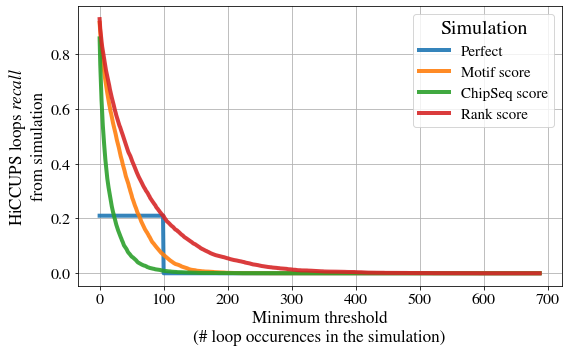

In [12]:
linewidth=4
alpha=0.9

fig = plt.figure(figsize=(8, 5))
plt.plot(ths_perfect, rec_perfect, label='Perfect', linewidth=linewidth, alpha=alpha)
plt.plot(ths_motifscore, rec_motifscore, label='Motif score', linewidth=linewidth, alpha=alpha)
plt.plot(ths_chipseqscore, rec_chipseqscore, label='ChipSeq score', linewidth=linewidth, alpha=alpha)
plt.plot(ths_rankaggscore, rec_rankaggscore, label='Rank score', linewidth=linewidth, alpha=alpha)
plt.legend(title='Simulation', title_fontsize=20, fontsize=15)
plt.xlabel("Minimum threshold\n(# loop occurences in the simulation)")
plt.ylabel("HiCCUPS loops $recall$\nfrom simulation")
fig.savefig(figure_path / "sim_vs_hiccups_recall.pdf", bbox_inches='tight', transparent=True)
plt.grid()
plt.show()

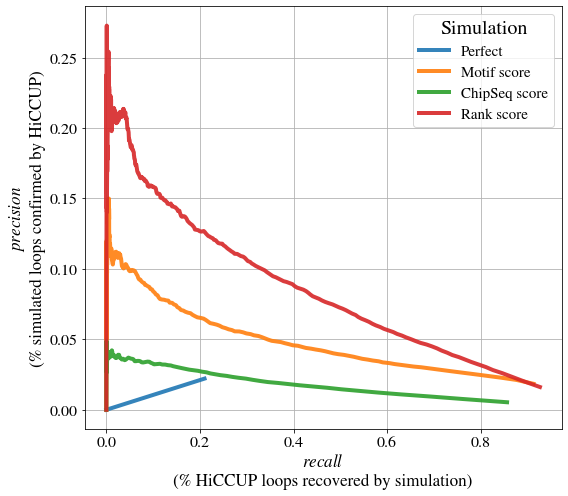

In [13]:
linewidth=4
alpha=0.9
fig = plt.figure(figsize=(8, 7))
plt.plot(*order_for_ROC(rec_perfect, prec_perfect), label='Perfect', linewidth=linewidth, alpha=alpha)
plt.plot(*order_for_ROC(rec_motifscore, prec_motifscore), label='Motif score', linewidth=linewidth, alpha=alpha)
plt.plot(*order_for_ROC(rec_chipseqscore, prec_chipseqscore), label='ChipSeq score', linewidth=linewidth, alpha=alpha)
plt.plot(*order_for_ROC(rec_rankaggscore, prec_rankaggscore), label='Rank score', linewidth=linewidth, alpha=alpha)
plt.legend()
plt.grid()
plt.legend(title='Simulation', title_fontsize=20, fontsize=15)
plt.xlabel("$recall$\n(% HiCCUP loops recovered by simulation)")
plt.ylabel("$precision$\n(% simulated loops confirmed by HiCCUP)")
fig.savefig(figure_path / "sim_vs_hiccups_recallprecision.pdf", bbox_inches='tight', transparent=True)
plt.show()